## Model comparison script

In [1]:
import pandas as pd
import numpy as np
import s3fs
import pyarrow.parquet as pq
import os
import fastparquet
import random
import statistics
import traceback
import ast
from collections import Counter
import langchain
import json
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Dict, List
import re
import string
from openai import RateLimitError, BadRequestError, APITimeoutError
import tiktoken
from dotenv import load_dotenv
import time
import logging
logger = logging.getLogger(__name__)
from tqdm.auto import tqdm
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
from unittest.mock import patch
load_dotenv("../_envvars.txt")

True

In [2]:
os.environ['LLM_MAX_LENGTH']

'15000'

In [3]:
s3 = s3fs.S3FileSystem()

In [109]:
contesting_models = ['roberta', 'scibert', 'deberta', 'biomed_roberta', 'cs_roberta']

In [112]:
# class_dict = {"human":0,"NLTK_synonym_replacement":1,"chatgpt":2,"summarized":3}
# class_labels_list = [0, 1, 2, 3]

In [7]:
def merged_model_predictions(path=None):
    if 's3://' in path:
        combined_df = pq.ParquetDataset(path, filesystem=s3).read_pandas().to_pandas()
        combined_df["tokens"] = combined_df.tokens.map(lambda x:ast.literal_eval(x.decode()))
    else:
        combined_df = pd.read_parquet(path,engine='fastparquet')
        #combined_df["tokens"] = combined_df.tokens.map(lambda x:ast.literal_eval(x.decode()))   
    return combined_df

In [12]:
path='data/merged_train_predictions.parquet'
combined_training_df = merged_model_predictions(path)
print(combined_training_df.columns)
print(combined_training_df.describe())

Index(['roberta_preds', 'scibert_preds', 'deberta_preds',
       'biomed_roberta_preds', 'cs_roberta_preds', 'text', 'tokens',
       'true_labels', 'roberta_f1_score', 'scibert_f1_score',
       'deberta_f1_score', 'biomed_roberta_f1_score', 'cs_roberta_f1_score'],
      dtype='object')
       roberta_f1_score  scibert_f1_score  deberta_f1_score  \
count       5000.000000       5000.000000       5000.000000   
mean           0.890101          0.892137          0.902066   
std            0.072697          0.073494          0.068171   
min            0.467366          0.482727          0.491797   
25%            0.859531          0.861742          0.874075   
50%            0.899727          0.902719          0.910865   
75%            0.933445          0.936690          0.943246   
max            1.000000          1.000000          1.000000   

       biomed_roberta_f1_score  cs_roberta_f1_score  
count              5000.000000          5000.000000  
mean                  0.890659     

In [14]:
#calculate the max F1 for each row and then also identify the model that is contributing to the max f1 score
def max_f1_score_and_model(row):
    index_list = ["roberta","scibert","deberta","biomed_roberta","cs_roberta"]    
    f1_scores = [row[f"{index_list[i]}_f1_score"] for i,_ in enumerate(index_list)]
    max_f1_score, model_with_max_score = max(f1_scores),index_list[f1_scores.index(max(f1_scores))]
    return {"max_f1_score":max_f1_score,"model_with_max_score":model_with_max_score}
combined_training_df[["max_f1_score","model_with_max_score"]]=combined_training_df.apply(lambda x:max_f1_score_and_model(x), axis=1,result_type="expand")
print(combined_training_df.columns)
combined_training_df.describe()

Index(['roberta_preds', 'scibert_preds', 'deberta_preds',
       'biomed_roberta_preds', 'cs_roberta_preds', 'text', 'tokens',
       'true_labels', 'roberta_f1_score', 'scibert_f1_score',
       'deberta_f1_score', 'biomed_roberta_f1_score', 'cs_roberta_f1_score',
       'max_f1_score', 'model_with_max_score'],
      dtype='object')


,roberta_f1_score,scibert_f1_score,deberta_f1_score,biomed_roberta_f1_score,cs_roberta_f1_score,max_f1_score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.890101,0.892137,0.902066,0.890659,0.890239,0.905594
std,0.072697,0.073494,0.068171,0.072569,0.071771,0.063503
min,0.467366,0.482727,0.491797,0.467366,0.490759,0.493620
25%,0.859531,0.861742,0.874075,0.859971,0.859250,0.876919
50%,0.899727,0.902719,0.910865,0.900814,0.899627,0.913187
75%,0.933445,0.936690,0.943246,0.934060,0.933423,0.944331
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

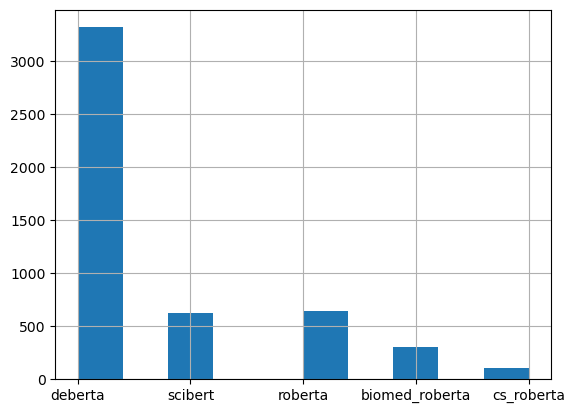

In [16]:
combined_training_df.model_with_max_score.hist()

In [114]:
#Load MAG-FOS Taxonomy JSON for different fields of study"
with open('MAG_FOS.json',"r+") as f:
    mag_fos_taxonomy = json.load(f)
mag_fos_taxonomy
major_fields_of_study = list(map(lambda x:x['field_of_study'],mag_fos_taxonomy["FOS"]))
major_fields_of_study_str = ",".join(major_fields_of_study)
sub_areas_within_major_field_of_study_list = list(map(lambda x:{x['field_of_study']:x['sub_fields']},mag_fos_taxonomy["FOS"]))
sub_areas_within_major_field_of_study = {list(fos.keys())[0]:fos[list(fos.keys())[0]] for fos in sub_areas_within_major_field_of_study_list}
sub_areas_within_major_field_of_study_str = "\n".join(f"{k}:{v}" for k,v in sub_areas_within_major_field_of_study.items())

In [115]:
#define Pydantic class for Structured output for article field of study
class ArticleFieldOfStudy(BaseModel):
    major_field_of_study: str = Field(description="The major field of study associated with the text of the article")
    sub_areas_within_major_field_of_study: List[str] = Field(description="A list sub areas within the major field of study associated with the text of the article")
    allied_field_of_study: List[str] = Field(description="List of other major fields of study associated with the text of the article")    

In [116]:
article_fos_dict_schema = convert_to_openai_tool(ArticleFieldOfStudy)

In [117]:
#Setup and test the LLM Instance for all tasks with respect to this analysis
llm_models = ['gpt-4-turbo-2024-04-09', 'gpt-3.5-turbo-0125']
llms = list(map(lambda x: ChatOpenAI(model=x, temperature=0, max_retries=0,request_timeout=120),llm_models))
llm_tests = list(map(lambda x:x.invoke("who are you, give me your model name and version?"),llms))
print(llms[1].request_timeout)

120.0


In [118]:
#Create a ChatPromptTempate for executing 
system = f'''Given an input text from a scientific article identify relevant information about the text.
            You can make use of the following major fields of study: {major_fields_of_study_str}
            You can also make use of the following sub areas within each major field of study listed above: {sub_areas_within_major_field_of_study_str}
         '''
prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "{input}"),]
)

In [119]:
#construct structured LLMs from input LLMs
structured_llm = llms[1].with_structured_output(article_fos_dict_schema)
structured_article_fos_chain = prompt | structured_llm
structured_article_fos_chain

ChatPromptTemplate(input_variables=['input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="Given an input text from a scientific article identify relevant information about the text.\n            You can make use of the following major fields of study: Art,Biology,Business,Chemistry,Computer Science,Economics,Engineering,Environmental Science,Geography,Geology,History,Materials Science,Mathematics,Medicine,Philosophy,Physics,Political Science,Psychology,Sociology\n            You can also make use of the following sub areas within each major field of study listed above: Art:['Aesthetics, Art History, Classics, Humanities, Literature, Visual Arts']\nBiology:['Anatomy, Animal Science, Bioinformatics, Botany, Genetics, Immunology, Zoology']\nBusiness:['Accounting, Actuarial Science, Commerce, Finance, International Trade, Marketing']\nChemistry:['Biochemistry, Food Science, Mineralogy, Organic Chemistry, Radiochemistry']\nComputer Science:['Alg

In [ ]:
def get_max_repeated_pred(input_df):
    input_df['preds'] = None
    input_df['majority_model'] = 'baseline'
    input_df['majority_col'] = None
    for index, row in input_df.iterrows():
        combined_preds_max = [0] * len(row['tokens'])
        majority_model_prediction = ['baseline'] * len(row['tokens'])
        majority_col_val = [0] * len(row['tokens'])
    
        for i in range(len(row['tokens'])):
            preds_data = [row['roberta_preds'][i], row['scibert_preds'][i], row['deberta_preds'][i],
                              row['biomed_roberta_preds'][i], row['cs_roberta_preds'][i]]
            
            max_repeated = statistics.multimode(preds_data)
            if len(max_repeated) != 1:
                # Weighted avg
                combined_preds_max[i] = random.choices(
                    preds_data, weights=[model_weights['roberta'], model_weights['scibert'],
                                         model_weights['deberta'], model_weights['biomed_roberta'], 
                                         model_weights['cs_roberta']],
                    k=1)[0]
                if combined_preds_max[i] == row['deberta_preds'][i]:
                    majority_model_prediction[i] = 'deberta'
                elif combined_preds_max[i] == row['biomed_roberta_preds'][i]:
                    majority_model_prediction[i] = 'biomed_roberta'
                elif combined_preds_max[i] == row['roberta_preds'][i]:
                    majority_model_prediction[i] = 'roberta'
                elif combined_preds_max[i] == row['cs_roberta_preds'][i]:
                    majority_model_prediction[i] = 'cs_roberta'
                else:
                    majority_model_prediction[i] = 'scibert'
                majority_col_val[i] = 0
            else:
                combined_preds_max[i] = max_repeated[0]
                if (row['deberta_preds'][i] == row['biomed_roberta_preds'][i]) and \
                (row['roberta_preds'][i] == row['biomed_roberta_preds'][i]) and \
                (row['roberta_preds'][i] == row['scibert_preds'][i]) and \
                (row['deberta_preds'][i] == row['scibert_preds'][i]) and \
                (row['cs_roberta_preds'][i] == row['scibert_preds'][i]):
                    majority_model_prediction[i] = 'all'
                else:
                    majority_model_prediction[i] = 'majority'
                majority_col_val[i] = 1
        input_df.at[index,'preds'] = combined_preds_max
        input_df.at[index, 'majority_model'] = majority_model_prediction
        input_df.at[index, 'majority_col'] = majority_col_val
    return input_df

### Function calls to make the predictions and save the parquet file

In [65]:
%%time
merged_model_dev_predictions = merge_model_predictions()

Data shape after merging with roberta model (5000, 3)
Data shape after merging with scibert model (5000, 4)
Data shape after merging with deberta model (5000, 5)
Data shape after merging with biomed_roberta model (5000, 6)
Data shape after merging with cs_roberta model (5000, 7)
CPU times: user 1min 30s, sys: 2.37 s, total: 1min 32s
Wall time: 1min 36s


In [66]:
merged_model_dev_predictions.head()

,text,tokens,roberta_preds,scibert_preds,deberta_preds,biomed_roberta_preds,cs_roberta_preds
index,,,,,,,
12313,Phylogenetic networks are a generalization of ...,"[Phylogenetic, networks, are, a, generalizatio...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3172,Prediction modelling is more closely aligned w...,"[Prediction, modelling, is, more, closely, ali...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6451,The heat transfer exhibits the flow of heat (t...,"[The, heat, transfer, exhibits, the, flow, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4351,a common experience during superficial ultraso...,"[a, common, experience, during, superficial, u...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
22694,Code metadata Current code version v1.5.9 Perm...,"[Code, metadata, Current, code, version, v1.5....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
%%time
#outputs = list(map(lambda x:x.invoke({"input":input_text}),structured_article_fos_chains))
chain = structured_article_fos_chain

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [68]:
input_text_with_index = pd.DataFrame(merged_model_dev_predictions['text'])
input_text_with_index_dict = input_text_with_index.to_dict('index')

In [ ]:
import math
def create_batches(input_text_index_dict):
    length_of_data = len(list(input_text_index_dict.keys()))
    batch_size = 100
    nbatches = math.ceil(length_of_data/batch_size)
    batches_of_keys = []
    key_list = list(input_text_index_dict.keys())
    for i in range(0,nbatches):
        a_batch_of_keys = key_list[i*batch_size:(i+1)*batch_size]
        batches_of_keys.append(a_batch_of_keys)
    batches = list(map(lambda x:{key:input_text_index_dict.get(key,"")["text"] for key in x},batches_of_keys))
    return batches
batches = create_batches(input_text_with_index_dict)
batch_sizes = [len(b) for b in batches]
batch_sizes

In [ ]:
batch = batches[0]
input_texts = [batch[key] for key in list(batch.keys())]
results = chain.batch(input_texts)
results

In [141]:
def populate_field_of_study(batches,load_last_checkpt=None,checkpt=True):
    LLM_MAX_LENGTH = os.getenv('LLM_MAX_LENGTH',16000)
    LLM_MAX_LENGTH=int(LLM_MAX_LENGTH)
    results_batches = []
    rate_limit_delay = 5
    checkpt_dict={}
    i=0
    while i < len(batches):
        if load_last_checkpt is not None:
            with open(load_last_checkpt,"r+") as f:
                checkpt_dict=json.load(f)
            f.close()
            i = int(load_last_checkpt.strip('.json').split('_')[2])-1
            print(f"Loaded Last checkpointed batch {i+1}")
            results_batches = checkpt_dict[f"Batch_{i+1}"]
            last_chekpt = load_last_checkpt.strip('.json')
            load_last_checkpt = None
            i+=1
            if i<len(batches):
                batch = batches[i]
            else:
                return results_batches, last_chekpt
        else:
            batch = batches[i]
        print(f"Processing Batch {i+1}")
        input_texts=[batch[key] for key in list(batch.keys())]
        try:
            results = chain.batch(input_texts)
        except APITimeoutError:
            checkpt_dict[f"Batch_{i+1}"] = results_batches
            with open(f"checkpt_batch_{i+1}.json","w+") as f:
                json.dump(checkpt_dict,f)
            f.close()
            last_checkpt=f"checkpt_batch_{i+1}"
        except RateLimitError:
            delay = 30
            print(f"Rate Limit Error Encountered, sleeping for {delay} seconds")
            time.sleep(delay)
            results = chain.batch(input_texts)
            rate_limit_delay *=2
            print(f"Doubling rate limit delay between batches to {rate_limit_delay} seconds")
        except BadRequestError:
            print(f"Bad Request Error Hit, adjusting input text length to accomodate model context")
            encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
            encoded_input_texts = list(map(lambda x:encoding.encode(x),input_texts))
            num_tokens_for_texts = list(map(lambda x:len(x),encoded_input_texts))
            clipped_input_texts = []
            for j,encoded_text in enumerate(encoded_input_texts):
                num_tokens = len(encoded_text)
                if num_tokens > LLM_MAX_LENGTH:
                    print(f"In Batch {i+1}, text {j+1} has {num_tokens} tokens, reducing it down to {LLM_MAX_LENGTH}")
                    clipped_input_texts.append(encoding.decode(encoded_text[:LLM_MAX_LENGTH]))
                else:
                    #print(f"In Batch {i+1}, text {j+1} has {num_tokens} tokens, NOT reducing the tokens")
                    clipped_input_texts.append(encoding.decode(encoded_text))
            try:
                results = chain.batch(clipped_input_texts)
            except RateLimitError:
                delay = 30
                print(f"Rate Limit Error Encountered, sleeping for {delay} seconds")
                time.sleep(delay)
                results = chain.batch(clipped_input_texts)
                rate_limit_delay *=2
                print(f"Doubling rate limit delay between batches to {rate_limit_delay} seconds")
        batch_result_dict = {key:results[i] for i,key in enumerate(list(batch.keys()))}
        results_batches.append(batch_result_dict)
        if checkpt:
            checkpt_dict[f"Batch_{i+1}"] = results_batches
            with open(f"checkpt_batch_{i+1}.json","w+") as f:
                json.dump(checkpt_dict,f)
            f.close()
            last_checkpt=f"checkpt_batch_{i+1}"
        if i+2<=len(batches):
            print(f"Sleeping for {rate_limit_delay} seconds before processing batch {i+2}")
        time.sleep(rate_limit_delay)
        if i<len(batches):
            i+=1
    return results_batches, last_chekpt

In [ ]:
%%time
last_checkpt=None
results_batches, last_checkpt = populate_field_of_study(batches,load_last_checkpt=f"{last_checkpt}.json" if last_checkpt is not None else None)
last_checkpt

In [ ]:
merged_model_dev_predictions[['major_field_of_study','sub_areas_within_major_field_of_study','allied_fields_of_study']] = merged_model_dev_predictions.apply(lambda x:populate_field_of_study(x),axis=1,result_type='expand')

In [ ]:
merged_model_dev_predictions.columns

In [ ]:
%%time
majority_vote_df = get_max_repeated_pred(merged_model_dev_predictions)
majority_vote_df.head()

In [ ]:
majority_vote_df[['preds']].to_parquet('predictions_four_models.parquet')

In [ ]:
majority_vote_df.head()

# End here

### Finding the stats about the majority column

In [ ]:
def get_model_stats(row):
    stats_dict = row['stats']
    out_dict = {}
    out_keys =  ['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']
    out_dict = {key:stats_dict[key] if key in list(stats_dict.keys()) else 0 for key in out_keys}
    
    return out_dict

In [ ]:
majority_vote_df['stats'] = majority_vote_df[['majority_model']].map(lambda x: Counter(x))
# majority_vote_df.head()

In [ ]:
stats_df = majority_vote_df[['tokens', 'stats', 'majority_col']]
stats_df.head()

In [ ]:
stats_df['len_tokens'] = stats_df['tokens'].map(lambda x : len(x))
stats_df.drop(columns=['tokens'], inplace=True)

In [ ]:
stats_df['sum_majority'] = stats_df['majority_col'].map(lambda x : sum(x))

In [ ]:
stats_df['sum_majority_not_all'] = stats_df['sum_majority'] - stats_df['all']
stats_df.head()

In [ ]:
stats_df['pct_majority'] = 100 * stats_df['sum_majority']/stats_df['len_tokens']

In [ ]:
stats_df[['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']] = stats_df.apply(
    lambda x : get_model_stats(x), axis=1, result_type='expand')

In [ ]:
stats_df.describe()

In [ ]:
stats_df['pct_majority'].hist()

In [ ]:
stats_df['roberta'].hist()

In [ ]:
stats_df['scibert'].hist()

In [ ]:
stats_df['deberta'].hist()

In [ ]:
stats_df['biomed_roberta'].hist()

In [ ]:
stats_df['all'].hist()

# For local runs

In [ ]:
base_folder = "/Users/gayatri/Documents/Gayatri/US/Self projects/AI Competition/DAGPAP24/data"

In [ ]:
dev_df = pd.read_parquet(base_folder + os.sep + 'dev_data.parquet', engine="fastparquet")
print(dev_df.shape)
dev_df.head()

In [ ]:
dev_df.columns

In [ ]:
merged = dev_df.copy(deep=True)

for model in contesting_models:
    model_df = pd.read_parquet(base_folder + os.sep + f'predictions_{model}.parquet', engine="fastparquet")
    model_df.rename(columns={'preds': f'{model}_preds'}, inplace=True)

    merged = merged.merge(model_df, how='inner', left_index=True, right_index=True)
    print(f"Data shape after merging with {model} model {merged.shape}")

In [ ]:
merged.head()

In [ ]:
%%time
max_pred_df = get_max_repeated_pred(merged)
print(max_pred_df.shape)
max_pred_df.isna().sum()

In [ ]:
0.88/(0.87+0.88+0.89)

In [ ]:
max_pred_df[['preds']].to_parquet(base_folder + os.sep + 'predictions_three_models_combined.parquet') # , engine="fastparquet")

In [ ]:
merged.head()

In [ ]:
merged.to_csv(base_folder + os.sep + 'dev_majority_model_preds.csv')

In [ ]:
merged.to_parquet(base_folder + os.sep + 'dev_majority_model_preds.parquet')